# 侧信道信息泄漏解析
<!---->

这里介绍侧信道信息泄漏的原因。数字电路在执行计算时会消耗功率，它们从电源中吸取电流，然后将接收到的能量以热的形式耗散。因此芯片在执行密码运算的时候会泄漏出可以被侧信道分析所利用的能量信息。

## CMOS电路的能量消耗

CMOS（互补金属氧化物半导体）电路是一种广泛应用于数字和模拟电子设备的集成电路技术，是芯片的基本组成单元。芯片的能量消耗来自于CMOS电路的能量消耗，CMOS电路能量消耗主要来源于两个方面：动态功耗和静态功耗。

1. **动态功耗（Dynamic Power Consumption）**：
   动态功耗是在电路进行开关动作时消耗的能量，即当晶体管在导通和截止之间切换时。这种功耗主要由以下公式决定：
   $ P_{dynamic} = \alpha \cdot C \cdot V_{DD}^2 \cdot f $      
   其中：  
       - $\alpha $ 是活动因子，表示电路中有多少比例的晶体管在单位时间内切换状态。  
       - $ C $ 是电路中电容的总和，包括晶体管的栅电容、互连线电容等。  
       - $ V_{DD} $ 是电源电压。  
       - $ f $ 是电路的频率，即晶体管每秒切换的次数。  

       动态功耗与电源电压的平方成正比，这意味着降低电压可以显著减少能量消耗。

2. **静态功耗（Static Power Consumption）**：
   静态功耗是在电路没有进行开关动作时仍然存在的功耗，主要是由于漏电流造成的。漏电流包括：  
       - **亚阈值漏电流（Subthreshold Leakage）**：即使晶体管处于关闭状态，由于半导体的物理特性，仍然会有微小的电流流过晶体管。  
       - **栅漏电流（Gate Leakage）**：随着技术节点的缩小，栅氧层变得更薄，导致栅极和衬底之间的漏电流增加。  
       - **体漏电流（Body Leakage）**：由于工艺不完美，晶体管的衬底和源/漏极之间可能存在漏电流。  

       静态功耗可以用以下公式表示：   
       $P_{static} = I_{leak} \cdot V_{DD}$   
       其中 $ I_{leak} $ 是漏电流，$ V_{DD} $ 是电源电压。

动态功耗在能量消耗中占主导地位，是侧信道分析所利用的主要能量消耗形式：在密码算法的某个特定时段内，如果电路状态的0→1转换和1→0转换的总数（即汉明距离）越大，那么该时段内的能量消耗也越大
<!---->


为了测量电路的能量消耗，可以在电路的电源或接地处串联一个小电阻，将电阻的电压降除以该电阻值就可以得到对应的电流值。也可以使用电磁探头来测量，电磁探头可以捕捉到由于电路状态变化引起的电磁辐射。这些变化与芯片内部逻辑门的状态变化相关，因为逻辑门电路状态的变化在物理上体现为电流的变化，从而消耗功率。

## NUT准备

使用xxx，将下述代码片段下载至。。。

```C
	volatile long int A = 0x2BAA;
	A *= 2;
	A *= 2;
	A *= 2;
	A *= 2;
	A *= 2;
	
	A *= 2;
	A *= 2;
	A *= 2;
	A *= 2;
	A *= 2;

	A *= 2;
	A *= 2;
	A *= 2;
	A *= 2;
	A *= 2;
	
	A *= 2;
	A *= 2;
	A *= 2;
	A *= 2;
	A *= 2;
```

这段代码运行的能量迹如下，可见能清晰地看到20次操作

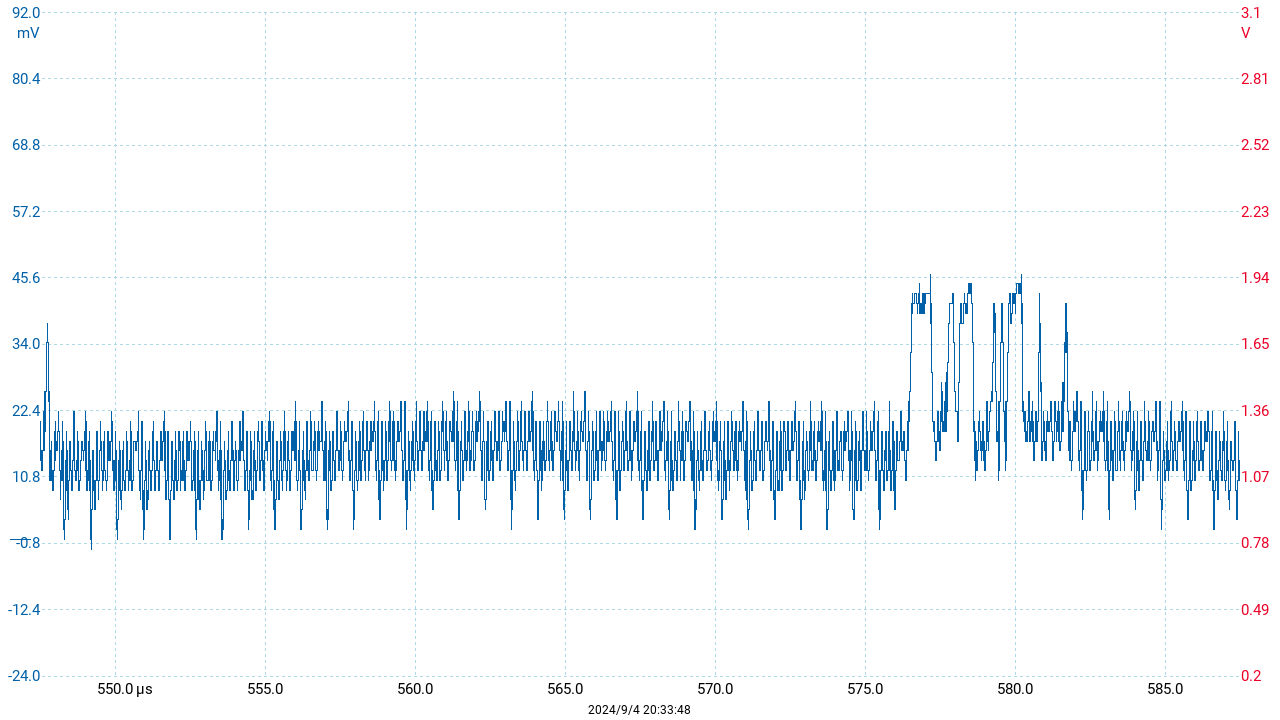

## 汉明距离模型

汉明距离模型假设所有的元件对能量消耗具有相同的影响，$0 \rightarrow 1$转换和$1 \rightarrow 0$转换具有同样的能量消耗。值$v_0$和$v_1$的汉明距离可以计算如下：HD$(v_0,v_1)$=HW$(v_0 \oplus v_1)$。

## 汉明重量模型

在汉明重量模型中，攻击者假设能量消耗与被处理的数据中被置位的比特个数成正比，而忽略该数据之前和之后处理的数值。值$v$的汉明重量为HW$(v)$，表示$v$的二进制表示中比特1的个数。汉明重量并不是一个准确的模型，但当无法采用汉明距离模型时，攻击者一般会选用汉明重量模型。

# Nut_stm32f103 AES侧信道曲线

In [3]:
import cracknuts as cn
# 引入波形文件数据集对象
from cracknuts.trace.trace import ScarrTraceDataset

In [ ]:
tap_cracker1_fix = cn.panel_trace()

采集Nut_stm32f103 AES运行过程的曲线

固定明文采集的曲线如下图所示：

In [ ]:
# 加载波形文件
scarr_trace_dataset_cracker1 = ScarrTraceDataset.load("dataset/nut103_aes_fix_data.zarr")
# 将数据集配置到波形显示面板
tap_cracker1_fix.set_trace_dataset(scarr_trace_dataset_cracker1)
# 显示第二通道的前十条曲线
tap_cracker1_fix.show_trace[0, :10] 
# 显示曲线分析面板
tap_cracker1_fix

TracePanelWidget(trace_series_list=[{'name': '0-0', 'data': array([  29,   20,   -2, ...,  -94, -129, -163], d…

In [25]:
from scarr.engines.stats import Stats as stats
from scarr.file_handling.trace_handler import TraceHandler as th
# from scarr.model_values.sbox_weight import SboxWeight
from scarr.container.container import Container, ContainerOptions
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
import numpy as np


In [36]:
dataset_name = 'dataset\\nut103_aes_fix_data.zarr'
handler = th(fileName=dataset_name) 
engine = stats()
container = Container(options=ContainerOptions(engine=engine, handler=handler))
container.run()

opened zarr file  dataset\nut103_aes_fix_data.zarr


计算1000条曲线均值

In [37]:
output_notebook() 
p = figure(width=1000, height=200, title="曲线均值")
p.line(np.arange(0, 20480), container.engine.get_means()[0,:].T, color="red")
hover = HoverTool()
hover.tooltips = [
    ("index", "$index"),
    ("(x,y)", "($x, $y)"),
]
p.add_tools(hover)
show(p)

Loading BokehJS ...

计算1000条曲线方差

In [38]:
output_notebook() 
p = figure(width=1000, height=200, title="曲线方差")
p.line(np.arange(0, 20480), container.engine.get_variances()[0,:].T, color="red")
hover = HoverTool()
hover.tooltips = [
    ("index", "$index"),
    ("(x,y)", "($x, $y)"),
]
p.add_tools(hover)
show(p)

Loading BokehJS ...

随机明文采集的曲线如下图所示：

In [ ]:
# 加载波形文件
scarr_trace_dataset_cracker1 = ScarrTraceDataset.load("dataset/nut103_aes_random_data.zarr")
# 将数据集配置到波形显示面板
tap_cracker1_fix.set_trace_dataset(scarr_trace_dataset_cracker1)
# 显示第二通道的前十条曲线
tap_cracker1_fix.show_trace[0, :10] 
# 显示曲线分析面板
tap_cracker1_fix

TracePanelWidget()

In [32]:
dataset_name = 'dataset\\nut103_aes_random_data.zarr'
handler2 = th(fileName=dataset_name) 
engine2 = stats()
container2 = Container(options=ContainerOptions(engine=engine2, handler=handler2))
container2.run()

opened zarr file  dataset\nut103_aes_random_data.zarr


计算1000条曲线均值

In [33]:
output_notebook() 
p = figure(width=1000, height=200, title="曲线均值")
p.line(np.arange(0, 20480), container2.engine.get_means()[0,:].T, color="red")
hover = HoverTool()
hover.tooltips = [
    ("index", "$index"),
    ("(x,y)", "($x, $y)"),
]
p.add_tools(hover)
show(p)

Loading BokehJS ...

计算1000条曲线方差

In [34]:
output_notebook() 
p = figure(width=1000, height=200, title="曲线方差")
p.line(np.arange(0, 20480), container2.engine.get_variances()[0,:].T, color="red")
hover = HoverTool()
hover.tooltips = [
    ("index", "$index"),
    ("(x,y)", "($x, $y)"),
]
p.add_tools(hover)
show(p)

Loading BokehJS ...

In [35]:
container2.engine.get_variances()[0,:]

array([11.199239, 11.5115  , 12.049799, ...,  5.307456,  5.585856,
        5.832375])

In [39]:
container.engine.get_variances()[0,:]

array([5.893036, 6.1099  , 6.615831, ..., 5.211184, 5.313391, 5.258919])